In [1]:
from tope import Tope
from tope.net import *
from tope.orth import *
from tests import normalize_polygon
from typing import *

import json, os, numpy as np
rng = np.random.default_rng()
with open("polys.json") as fd: polys = json.load(fd)

In [2]:
v_24cell = [
    [1, 0, 0, 0], [-1, 0, 0, 0],
    [0, 1, 0, 0], [0, -1, 0, 0],
    [0, 0, 1, 0], [0, 0, -1, 0], 
    [0, 0, 0, 1], [0, 0, 0, -1],
    [1, -1, 0, 0], [-1, 1, 0, 0], 
    [1, 0, -1, 0], [-1, 0, 1, 0], 
    [1, 0, 0, -1], [-1, 0, 0, 1], 
    [0, 1, -1, 0], [0, -1, 1, 0], 
    [0, 1, 0, -1], [0, -1, 0, 1],
    [1, 0, -1, -1], [-1, 0, 1, 1], 
    [0, 1, -1, -1], [0, -1, 1, 1],
    [1, 1, -1, -1], [-1, -1, 1, 1]
]

In [3]:
v_36cell = [
    (1, 0, 0, 0),
    (0, 0, 1, 0),
    (0, -1, 0, 0),
    (0, 0, 0, -1),
    (1, 1, 0, 0),
    (-1, -1, 0, 0),
    (0, 1, 0, 0),
    (-1, 0, 0, 0),
    (0, 0, 1, 1),
    (0, 0, 0, 1),
    (0, 0, -1, -1),
    (0, 0, -1, 0)
]

In [4]:
EdgeList = list[np.ndarray] # list of 2xdim arrays

def get_cuts(N: Net) -> EdgeList:
    return np.concatenate([N.tope.meta[2][i]["cuts"] for i in range(len(N.facets))])
        
        
def get_edges(N: Net) -> EdgeList: # apply to unfolded Net
    edges = []
    for i, vertices in N.facets.items():
        facet_template = N.tope.get_face(i) # has correct indices
        edges.extend((vertices[list(e)] for e in facet_template.faces[1]))
    return edges

import itertools

Net2d = None # new format of Net

def iter_edges(N: Net2d) -> Iterable[np.ndarray[2,2]]: # apply to unfolded 2d Net
    return N.iter_faces_as_vertices(dim=1)

FacetLabels = list[tuple[str, np.ndarray]] # label, position

def get_facet_labels(N: Net) -> FacetLabels:
    labels = []
    for i, vertices in N.facets.items():
        labels.append((N.tope.meta[N.tope.dim-1][i]["index"], vertices.mean(axis=0)))
    return labels

def iter_facet_labels(N: Net2d, key: str) -> Iterable[str]:
    return zip(N.iter_meta(dim=2, key="index"), map(N.cells.values(), lambda x: x.vertices.mean(axis=0)))

In [5]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection # container for line segments
from matplotlib.text import Text, Annotation
import matplotlib.cm as cm # colour mappings
import matplotlib as mpl

In [6]:
def get_net_for_facet(P: Tope, i: int, keys=[]) -> Net:
    F = P.get_facet(i, meta_keys=keys)
    G = get_facet_graph(F)
    T = G.get_spanning_tree()
    N = Net(F, T).unfold_with_meta(meta_keys=keys).in_own_span(meta_keys=keys)
    return N

In [29]:
MARGIN_FACTOR = 0.05

from tope.plot import bounding_bbox, plot_artists_in_view

def plot_nets(
    P: Tope, 
    name: str = "P", 
    margin: float = MARGIN_FACTOR, 
    dpi: int = 300, 
    force=False, 
    fmt="svg",
    label_config: dict = {"fontsize": 2, "ha": "center", "va": "center"},
    title_config: dict = {"fontsize": 8, "pad": -14},
    hatch = False,
    label = True
):    
    nfacets = len(P.faces[P.dim-1])
    nets = [get_net_for_facet(P, i, keys=["cuts"]) for i in range(nfacets)] if hatch \
        else [get_net_for_facet(P, i) for i in range(nfacets)]
    
    ## compute common bounding box
    
    bbox = bounding_bbox(*(cell for N in nets for cell in N.facets.values()))
    
    #xlim, ylim = compute_bounding_box(*(cell for N in nets for cell in N.facets.values()), margin_factor=margin_factor)
    
    ## generate images
    figs = []
    for i, N in enumerate(nets):
        artists = [LineCollection(get_edges(N), colors="grey", linewidths=0.2)]
        
        if hatch: artists.append(
            LineCollection(get_cuts(N), colors="lightgrey", linewidths=0.05)
        )
            
        if label: artists.extend(
            Text(*pos, text=str(l), **label_config) for l, pos in get_facet_labels(N)
        )
        
        # draw the actual picture
        fig, ax = plot_artists_in_view(*artists, bbox = bbox, margin = margin)
        
        facet_name = f"{name}-facet-{i}"
        # title with "default" positioning
        ax.set_title(facet_name, **title_config)
                
        # store and next()
        figs.append((facet_name, fig))
    
    return figs

In [8]:
def get_hyperplanes(*planes, spacing=0.02, r=5):
    return [H for L in planes for H in [(L, i*L) for i in np.arange(-r, r, spacing)]]

hyperplanes = get_hyperplanes(
    *(rng.integers(-5,5,size=4) for _ in range(4)), spacing=0.02
#    *(rng.normal(size=4) for _ in range(4))
#    np.array([1,0,0,0]), np.array([0,1,0,0]), np.array([0,0,1,0]), np.array([0,0,0,1])
)

2022-12-01 14:13:09.417 | DEBUG    | tope.tope:from_vertices:92 - Computing from set of 12 vertices.
2022-12-01 14:13:09.417 | DEBUG    | tope.tope:from_vertices:101 - Found 36 facets.
2022-12-01 14:13:09.462 | DEBUG    | tope.tope:from_vertices:144 - Finished processing faces:
 [[{0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}], [{0, 2}, {8, 2}, {8, 5}, {9, 2}, {9, 5}, {2, 11}, {11, 5}, {10, 2}, {10, 5}, {5, 7}, {1, 2}, {2, 3}, {2, 5}, {1, 5}, {3, 5}, {10, 7}, {11, 7}, {3, 7}, {9, 7}, {1, 7}, {8, 7}, {6, 7}, {8, 6}, {1, 6}, {9, 6}, {3, 6}, {11, 6}, {10, 6}, {4, 6}, {10, 11}, {10, 3}, {0, 10}, {10, 4}, {9, 11}, {0, 11}, {11, 4}, {1, 3}, {0, 3}, {3, 4}, {8, 9}, {0, 9}, {9, 4}, {8, 1}, {0, 1}, {1, 4}, {0, 8}, {8, 4}, {0, 4}], [{0, 8, 2}, {0, 1, 2}, {0, 9, 2}, {0, 2, 3}, {0, 2, 11}, {0, 2, 10}, {8, 1, 2}, {8, 1, 5}, {8, 5, 7}, {8, 9, 2}, {8, 2, 5}, {8, 9, 5}, {9, 2, 11}, {9, 2, 5}, {9, 5, 7}, {9, 11, 5}, {10, 2, 11}, {2, 11, 5}, {11, 5, 7}, {10, 11, 5}, {10, 5, 7}, {3, 10, 2}

2022-12-01 14:13:09.595 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 140.77 degrees...
2022-12-01 14:13:09.595 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 108.43 degrees...
2022-12-01 14:13:09.595 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 109.47 degrees...
2022-12-01 14:13:09.595 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 109.47 degrees...
2022-12-01 14:13:09.595 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 109.47 degrees...
2022-12-01 14:13:09.612 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 109.47 degrees...
2022-12-01 14:13:09.612 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 109.47 degrees...
2022-12-01 14:13:09.612 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 109.47 degrees...
2022-12-01 14:13:09.612 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 108.43 degrees...
2022-12-01 14:13:09.617 | DEBUG    | tope.orth

Decorations calculated. Unfolding...


2022-12-01 14:13:09.648 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 144.74 degrees...
2022-12-01 14:13:09.648 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 90.00 degrees...
2022-12-01 14:13:09.648 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 109.47 degrees...
2022-12-01 14:13:09.648 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 144.74 degrees...
2022-12-01 14:13:09.648 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 90.00 degrees...
2022-12-01 14:13:09.648 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 144.74 degrees...
2022-12-01 14:13:09.648 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 109.47 degrees...
2022-12-01 14:13:09.648 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 144.74 degrees...
2022-12-01 14:13:09.648 | DEBUG    | tope.orth:rotate_into_hyperplane:163 - Rotating by 144.74 degrees...
2022-12-01 14:13:09.664 | DEBUG    | tope.orth:r

2022-12-01 14:13:09.849 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(-3.700743415417188e-17, -3.700743415417188e-17, '8').
2022-12-01 14:13:09.849 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(0.6589510811414448, 0.10113316521777348, '11').
2022-12-01 14:13:09.849 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(0.7374636857110124, -0.6120377742544136, '14').
2022-12-01 14:13:09.849 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(1.508289306341805, -0.3427896930248154, '37').
2022-12-01 14:13:09.864 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist <matplotlib.collections.LineCollection object at 0x0000014F7EEA4FD0>.
2022-12-01 14:13:09.864 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(0.0, -4.2789845740761244e-17, '9').
2022-12-01 14:13:09.880 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(-0.7047877390916956, -0.13435498059229137, '10').
2022-12-

2022-12-01 14:13:10.150 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(2.247130535898201, -0.1538640559362651, '49').
2022-12-01 14:13:10.165 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist <matplotlib.collections.LineCollection object at 0x0000014F7E97A040>.
2022-12-01 14:13:10.165 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(-2.7755575615628914e-17, -3.700743415417188e-17, '33').
2022-12-01 14:13:10.165 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(-0.7650553239294648, -0.285231516480645, '34').
2022-12-01 14:13:10.165 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(-1.3946007251263957, 0.23471007110248157, '38').
2022-12-01 14:13:10.181 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(-2.1596560490558607, -0.0505214453781635, '47').
2022-12-01 14:13:10.181 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist <matplotlib.collections.LineCollection object a

2022-12-01 14:13:10.366 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(1.042230785439263, 0.11679725763060474, '57').
2022-12-01 14:13:10.366 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(1.653112041822455, -0.1501644157312038, '58').
2022-12-01 14:13:10.381 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(2.6953428272617175, -0.033367158100599724, '64').
2022-12-01 14:13:10.381 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist <matplotlib.collections.LineCollection object at 0x0000014F7EAF6D90>.
2022-12-01 14:13:10.397 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(0.0, 0.0, '59').
2022-12-01 14:13:10.397 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(-0.8965536791666127, 0.26639712410082445, '60').
2022-12-01 14:13:10.397 | DEBUG    | tope.plot:plot_artists_in_view:91 - Adding artist Text(-1.500151074350368, -0.14129058783784085, '61').
2022-12-01 14:13:10.397 | DEBUG 

Got the nets!


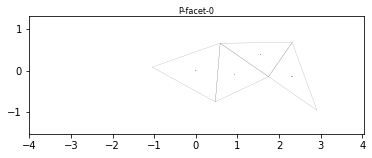

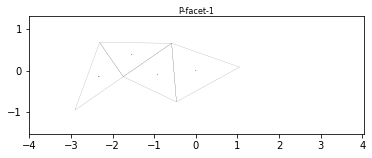

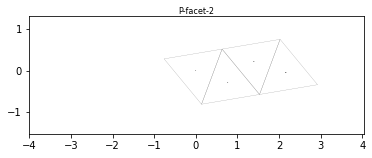

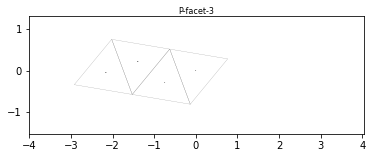

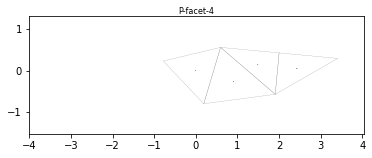

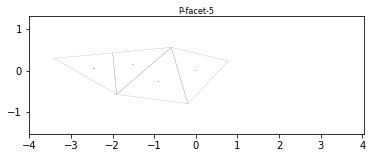

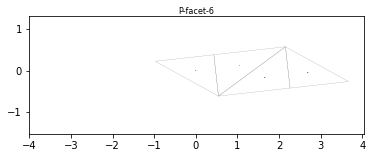

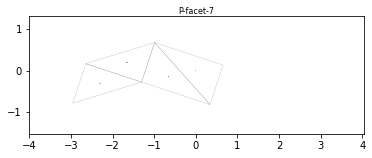

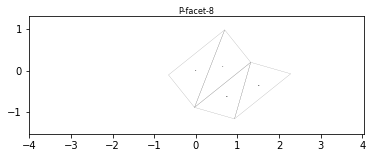

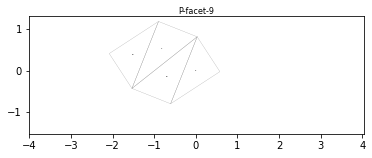

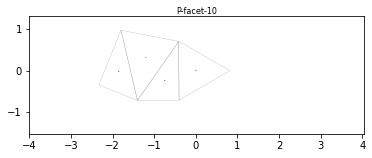

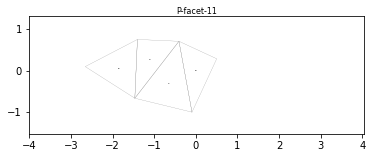

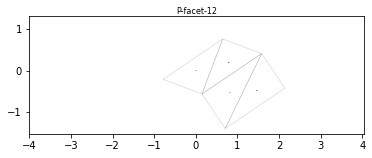

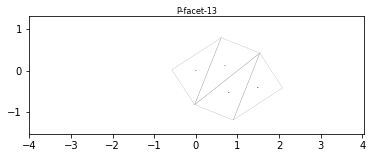

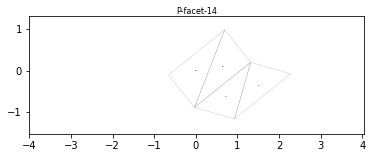

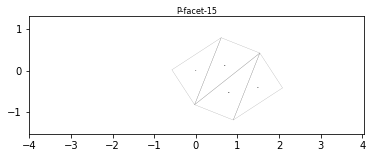

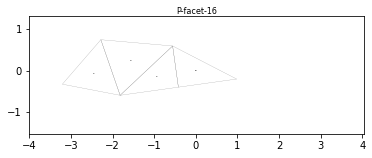

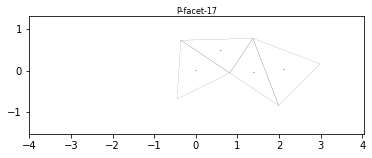

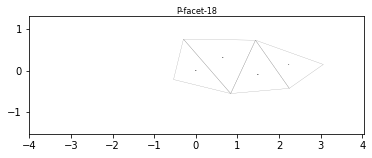

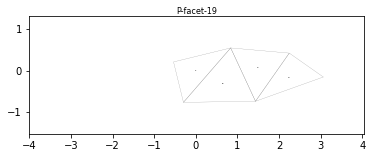

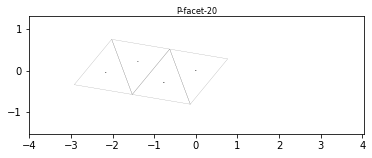

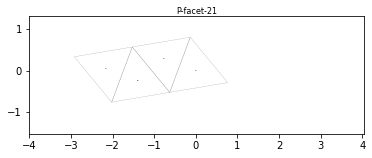

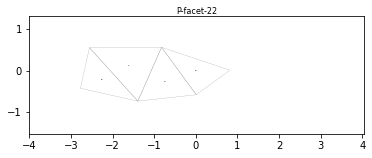

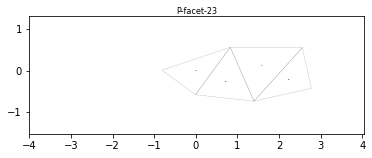

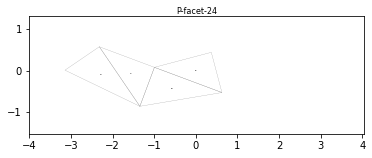

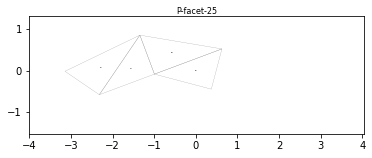

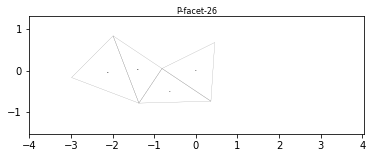

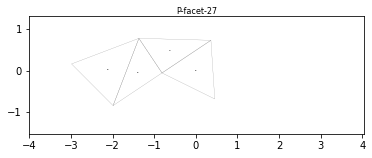

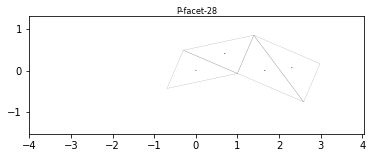

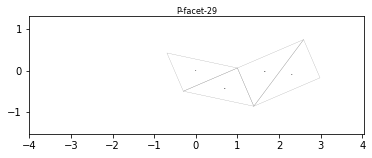

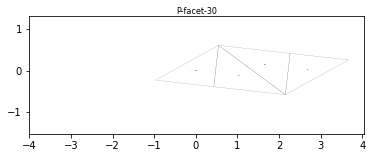

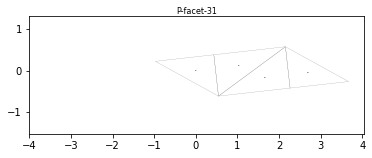

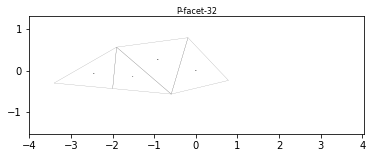

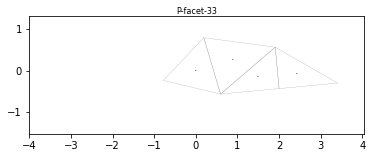

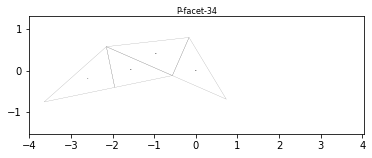

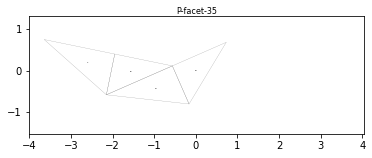

In [30]:
P = Tope.from_vertices(v_36cell)
P.save_index()
#P.cut_2faces_with_hyperplanes(hyperplanes)
print("Decorations calculated. Unfolding...")
nets = plot_nets(P)

print("Got the nets!")

from tope.plot import save_figs_to_dir, save_figs_to_zip
save_figs_to_zip(nets, path="tmp/36-cell-test.zip", fmt="png", dpi=600)
#save_nets(P, "figs/4902603", force=True, fmt="svg")

In [24]:
save_figs_to_dir(nets, directory="tmp/qq", fmt="svg")

In [28]:
os.listdir("tmp/qq")

['0.svg',
 '1.svg',
 '10.svg',
 '11.svg',
 '12.svg',
 '13.svg',
 '14.svg',
 '15.svg',
 '16.svg',
 '17.svg',
 '18.svg',
 '19.svg',
 '2.svg',
 '20.svg',
 '21.svg',
 '22.svg',
 '23.svg',
 '24.svg',
 '25.svg',
 '26.svg',
 '27.svg',
 '28.svg',
 '29.svg',
 '3.svg',
 '30.svg',
 '31.svg',
 '32.svg',
 '33.svg',
 '34.svg',
 '35.svg',
 '4.svg',
 '5.svg',
 '6.svg',
 '7.svg',
 '8.svg',
 '9.svg']

In [ ]:
P = Tope.from_vertices(v_24cell)
P.save_index() # now must do this before passing to sub-topes
P.cut_2faces_with_hyperplanes(hyperplanes) # and this
save_nets(P, "figs/24cell", force=True)

In [ ]:
P = Tope.from_vertices(polys["2070"])
P.save_index() # now must do this before passing to sub-topes
save_nets(P, "figs/2070", force=True)

In [ ]:
#save_nets(Tope.from_vertices(polys["2070"]), "figs/2070", force=True)

In [ ]:
for name, poly in polys.items():
    pass # TODO. fix this
    #save_nets(Tope.from_vertices(poly), f"figs/{name}", force=True)

In [90]:
with open("../polys1.json") as fd: data = json.load(fd)
v_bigboy = data["4902603"]